# Proyecto: Predicción de Alzheimer a partir de MRI usando Deep Learning




## **0. Integrantes del equipo de trabajo**
---
1. RAÚL RAMÍREZ PENAGOS
2. IVÁN QUEVEDO
3. LINA ÁVILA MORENO

## **1. Entendimiento de los datos**

El conjunto de datos contiene 4 clases y etiquetas del 0 al 3:

1. Non demented : '0'
2. Very midly demented : '1'
3. Mildly demented : '2'
4. Moderately demented : '3'

In [2]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import hashlib
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_train = pd.read_parquet('/content/drive/MyDrive/DIPLOMADO2/PROYECTO3_MLDS_AVANZADO/train.parquet')
df_test = pd.read_parquet('/content/drive/MyDrive/DIPLOMADO2/PROYECTO3_MLDS_AVANZADO/test.parquet')

In [5]:
df_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [6]:
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1280 non-null   object
 1   label   1280 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB


In [9]:
#Creación de la carpeta de destino solicitada en data_definition.md (entregable 2)
dest_dir = "/content/drive/MyDrive/DIPLOMADO2/PROYECTO3_MLDS_AVANZADO/procesado/"
os.makedirs(dest_dir, exist_ok=True)

In [10]:
etiqueta_enfermedad_categoria = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [11]:
def decodificar_imagen(image_dict):
    if isinstance(image_dict, dict) and "bytes" in image_dict:
        byte_string = image_dict["bytes"]
        datos_raw_np = np.frombuffer(byte_string, np.uint8)

        # Cargar en escala de grises (1 canal)
        img = cv2.imdecode(datos_raw_np, cv2.IMREAD_GRAYSCALE)

        # Redimensionar
        img = cv2.resize(img, (224, 224))

        # Expandir a 3 canales se replicó la imagen en gris
        img_3ch = np.stack([img, img, img], axis=-1)

        return img_3ch

    else:
        raise TypeError(f"Se esperaba un diccionario {type(image_dict)}")

In [12]:
#Verifico que tenga los 3 canales
img_dict = df_train["image"].iloc[0]
img_3ch = decodificar_imagen(img_dict)
print(img_3ch.shape)

(224, 224, 3)


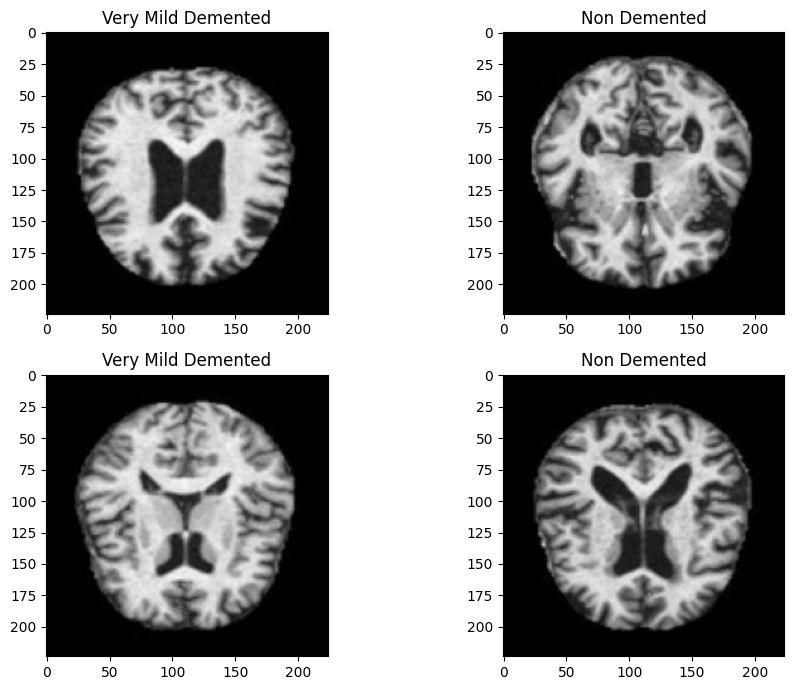

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_train))
    decoded_image = decodificar_imagen(df_train.iloc[rand]['image'])
    axes.imshow(decoded_image, cmap="gray")
    axes.set_title(etiqueta_enfermedad_categoria[df_train.iloc[rand]['label']])
plt.tight_layout()
plt.show()

In [14]:
#Valores Faltantes
print(df_train.isnull().sum())

image    0
label    0
dtype: int64


In [15]:
#Valores Faltantes
print(df_test.isnull().sum())

image    0
label    0
dtype: int64


## **2. Limpieza de los datos**

In [16]:
#Imágenes corruptas

df_train['img_arr'] = df_train['image'].apply(decodificar_imagen)
df_test['img_arr'] = df_test['image'].apply(decodificar_imagen)


def imagen_valida(img_array):
    return img_array is not None and img_array.size > 0


In [17]:
# Aplicar validación de imágenes corruptas en df_train
init_train = len(df_train)
df_train = df_train[df_train["img_arr"].apply(imagen_valida)]
cleaned_train = len(df_train)
print(f"Filas de entrenamiento antes de limpiar: {init_train}")
print(f"Filas de entrenamiento después de limpiar: {cleaned_train}")
print(f"Filas de entrenamiento eliminadas: {init_train - cleaned_train}")

Filas de entrenamiento antes de limpiar: 5120
Filas de entrenamiento después de limpiar: 5120
Filas de entrenamiento eliminadas: 0


In [18]:
# Aplicar validación de imágenes corruptas en df_test
init_test = len(df_test)
df_test = df_test[df_test["img_arr"].apply(imagen_valida)]
cleaned_test = len(df_test)
print(f"Filas de prueba antes de limpiar: {init_test}")
print(f"Filas de prueba después de limpiar: {cleaned_test}")
print(f"Filas de prueba eliminadas: {init_test - cleaned_test}")

Filas de prueba antes de limpiar: 1280
Filas de prueba después de limpiar: 1280
Filas de prueba eliminadas: 0


In [19]:
#Duplicados

def hash_image(img):
    return hashlib.md5(img.tobytes()).hexdigest()

df_train["hash"] = df_train["img_arr"].apply(hash_image)
df_test["hash"] = df_test["img_arr"].apply(hash_image)

duplicados = df_train.duplicated(subset="hash").sum()
print("Número de imágenes duplicadas en train:", duplicados)

duplicados_test = df_test.duplicated(subset="hash").sum()
print("Número de imágenes duplicadas en test:", duplicados_test)

Número de imágenes duplicadas en train: 0
Número de imágenes duplicadas en test: 0


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5120 non-null   object
 1   label    5120 non-null   int64 
 2   img_arr  5120 non-null   object
 3   hash     5120 non-null   object
dtypes: int64(1), object(3)
memory usage: 160.1+ KB


In [21]:
#Elimino la columna hash creada previamente
df_train = df_train.drop(columns="hash")
df_test = df_test.drop(columns="hash")

In [22]:
#df_train.info()

In [23]:
#Balanceo de clases
df_train["label"].value_counts()

,count
label,
2,2566
3,1781
0,724
1,49


/tmp/ipython-input-1021562858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', num_classes)


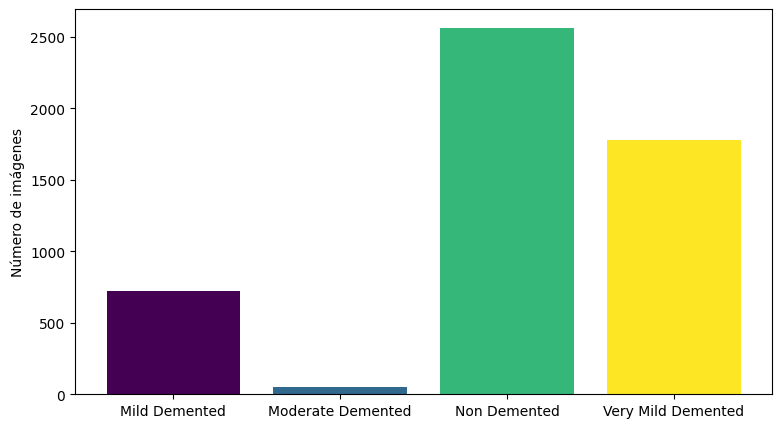

Total muestras en train = 5120


In [24]:
plt.figure(figsize=(9, 5))
num_classes = df_train['label'].nunique()
colors = cm.get_cmap('viridis', num_classes)
plt.bar(np.arange(0, 4, 1), df_train['label'].value_counts().sort_index(), color=[colors(i) for i in range(num_classes)])
plt.ylabel("Número de imágenes")
plt.xticks(np.arange(0, 4, 1), labels=[etiqueta_enfermedad_categoria[i] for i in range(4)])
plt.show()
print(f"Total muestras en train = {len(df_train)}")

In [25]:
df_train.head()

,image,label,img_arr
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [26]:
#Normalizar

# 1. Normalización de train
# Antes de normalizar
print("Antes de normalizar:")
print(df_train['img_arr'].iloc[0])
print("Valores mínimo y máximo:", df_train['img_arr'].iloc[0].min(), df_train['img_arr'].iloc[0].max())

# Aplicando normalización [0,1]
df_train['img_arr'] = df_train['img_arr'].apply(lambda x: x / 255.0)

# Después de normalizar
print("\nDespués de normalizar:")
print(df_train['img_arr'].iloc[0])
print("Valores mínimo y máximo:", df_train['img_arr'].iloc[0].min(), df_train['img_arr'].iloc[0].max())



Antes de normalizar:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Valores mínimo y máximo: 0 152

Después de normalizar:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [

In [27]:
# 1. Normalización de test
# Antes de normalizar
print("Antes de normalizar:")
print(df_test['img_arr'].iloc[0])
print("Valores mínimo y máximo:", df_test['img_arr'].iloc[0].min(), df_test['img_arr'].iloc[0].max())

# Aplicando normalización [0,1]
df_test['img_arr'] = df_test['img_arr'].apply(lambda x: x / 255.0)

# Después de normalizar
print("\nDespués de normalizar:")
print(df_test['img_arr'].iloc[0])
print("Valores mínimo y máximo:", df_test['img_arr'].iloc[0].min(), df_test['img_arr'].iloc[0].max())


Antes de normalizar:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Valores mínimo y máximo: 0 250

Después de normalizar:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [

## **3. Relaciones entre variables**

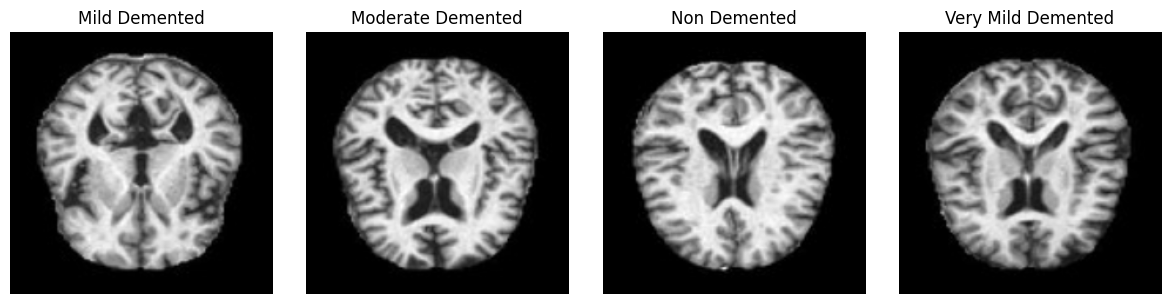

In [28]:
#Imágenes por clase
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
classes = [0, 1, 2, 3]

for i, c in enumerate(classes):
    img = df_train[df_train.label==c]["img_arr"].values[0]
    ax = axes[i]
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(etiqueta_enfermedad_categoria[c])
    ax.axis('off')

plt.tight_layout()
plt.show()


<Axes: xlabel='label', ylabel='mean_pixel'>

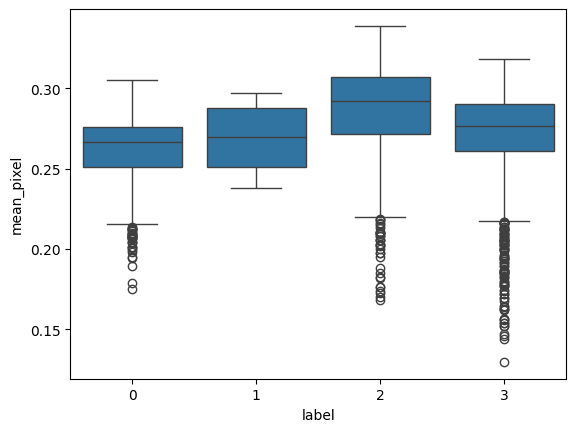

In [29]:
#Resumen estadístico por clase
df_train['mean_pixel'] = df_train['img_arr'].apply(lambda x: x.mean())
df_train['std_pixel']  = df_train['img_arr'].apply(lambda x: x.std())
sns.boxplot(x='label', y='mean_pixel', data=df_train)

In [30]:
df_train.groupby('label')['mean_pixel'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,724.0,0.261565,0.020895,0.175143,0.251252,0.266586,0.275757,0.305028
1,49.0,0.269928,0.019698,0.237911,0.250741,0.270024,0.287478,0.297239
2,2566.0,0.288007,0.025963,0.168323,0.271720,0.292223,0.307031,0.338836
3,1781.0,0.271430,0.027945,0.129747,0.260879,0.276483,0.290184,0.318497


In [ ]:
#PCA
